# TensorFlow CNN教程
# Convolutional Neural Network

by David Ruan

## 介绍

这个Notebook将实现一个简单的卷积神经网络，分类MNIST数据集，准确率达到大约99%。

卷积神经网络(或简称CNN）在输入图片上移动一些过滤器，所以，同一个过滤器会在整个图片上重复使用，扫描并识别其中的模式。因此，在变量数目同等情况下，训练CNN比训练全连接的神经网络更快。这就是CNN更强大的地方。


## CNN流程图

以下是一个简单的CNN实现的流程图

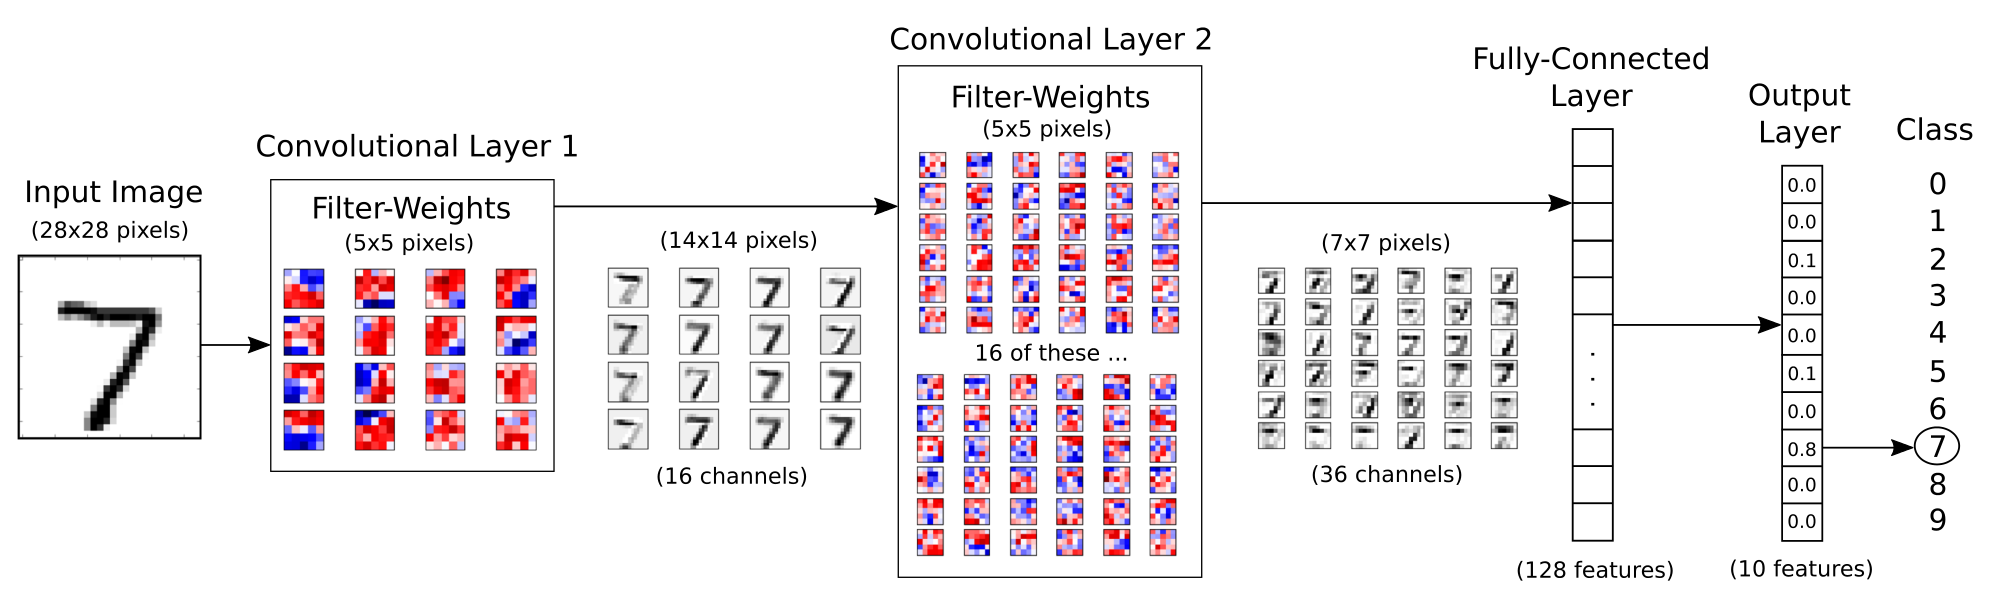

In [1]:
from IPython.display import Image
Image('images/network_flowchart.png')

这里总共有2个卷积层，2个全连接层。

输入的图片首先被第一个卷积层处理，通过16个5x5的过滤器，生成16个新图片，图片像素down-sample为14x14。

然后，这16个新图片（16个channel）被第二个卷积层处理，而这里的输出是36个channel，总共有16X36=576个过滤器。输出图片的像素down sample为7X7。

第二层的输出是36个7X7的图片，为了和下一个有128个神经元的全连接层相连，需要先转换为一个一维向量，因此其长度为36X7X7。

最后一个全连接层有10个神经元，每个对应一个数字。

CNN里的每个过滤器一开始都是随机的，因此分类结果也是随机的，分类结果和真实值的误差通过cross-entropy的方法计算。Tensorflow里的优化器会自动把误差传回CNN网络，并通过计算链式微分更新过滤器的值，使得误差减少。反复进行多次后，误差会显著减少。



## 卷积层

下面放大的图详细说明卷积层的操作。

过滤器上，红色代表正值，蓝色代表负值。

我们可以观察到过滤器是如何应用到图片上，在一个位置上图片和过滤器重复部分计算点积，结果输出为一个像素。然后过滤器移到下一个位置，再计算点积，并输出一个像素，最后生成新的图片。

在这个例子中，过滤器能识别到的模式是数字7的横线。

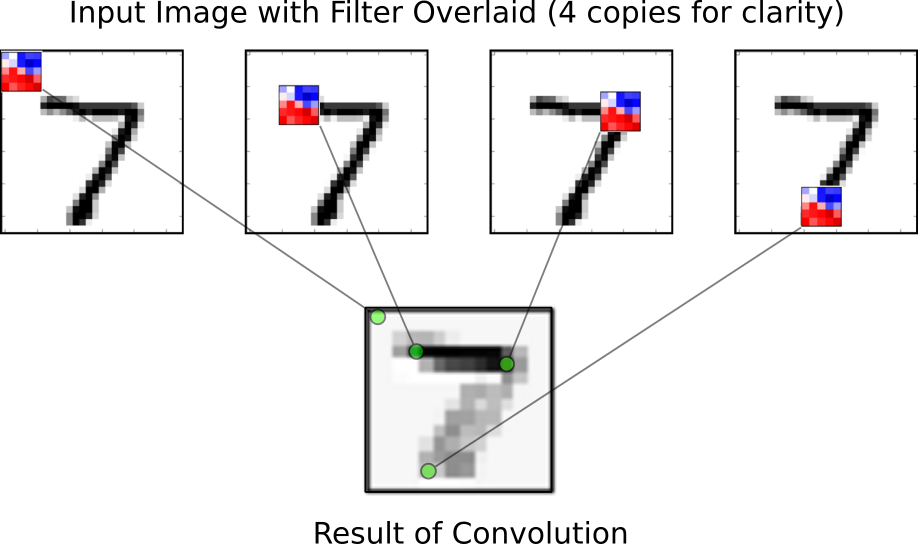

In [2]:
Image('images/convolution.png')

## Stride，Padding，ReLU和Max-Pooling

CNN里还有几个参数。
Stride是指过滤器移动的步长，Padding指当过滤器移到图片以外的位置时是否要用0（相当于白像素）来替代。
CNN的输出可以通过ReLU单元获得非线性。确保输出是正值或0。
通过Max-Poolinig可以缩小输出图片，比如2X2的Max-Pooling会把2X2窗口里的像素取其最大值，使得28X28像素的图片转为14X14像素。


## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

Tensorflow版本

In [4]:
tf.__version__

'1.1.0'

##  神经网络的设置参数

通过设置下面这些参数，测试和优化不同的参数组合

In [5]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## 加载MNIST数据

MNIST data-set的下载数据大概有12MB

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST data-set 总共有70，000张图片和它的标签，这些数据被分到3个数据集：train，test和validation。我们只需要train和test这两个数据集。

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


分类标签是one-hot编码，即每个标签都是一个长度为10的向量，数字所在位置的值为1，其他位置的值为0。下面获取其数字值，再测试时方便使用。

In [8]:
data.test.labels[0] #show an example of one-hot encoding example

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [9]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

数据的维度定义如下

In [10]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 辅助作图函数

辅助作图函数，用于显示图片和其分类结果和真实值。

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 16
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 使用辅助作图函数显示数据

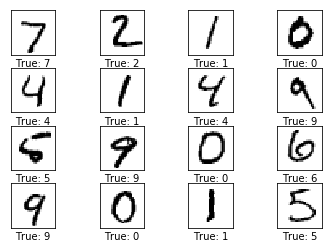

In [12]:
# Get the first images from the test-set.
images = data.test.images[0:16]

# Get the true classes for those images.
cls_true = data.test.cls[0:16]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

Tensorflow的目的在于把computaion graph放到Python以外执行，这使得计算更加高效，因为tensorflow知道整个computation graph。而Numpy只知道单个运算。

Tensorflow同时也可以自动计算梯度，优化computatioin graph里的变量。因为computation graph是有多个简单的数学表达式组成，通过链式微分，可以计算得到整个图的梯度。

Tensorflow还可以使用多核CPU，GPU和其他硬件执行。

一个Tensorflow图包括以下部分：

* Placeholder用于输入数据到图
* Variable可以在训练中优化,使得CNN预测结果更好
* CNN的数学方程
* Cost函数，用于指引Optimization去更新Variable
* Optimization方法，用于更新Variable



### 创建新Variable的辅助函数

下面的函数用于创建新的Variable，并初始化为随机值。

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05),name='weights')

In [14]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]),name='biases')

### 创建convolutional layer的辅助函数

convolutional layer的输入是4维的tensor，包含：
1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

输出也是一个4维的tensor，包含:
1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [15]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    with tf.name_scope("conv_layer"):
        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights aka. filters with the given shape.
        weights = new_weights(shape=shape)

        # Create new biases, one for each filter.
        biases = new_biases(length=num_filters)
        tf.summary.histogram("conv_weights", weights)
        tf.summary.histogram("conv_biases", biases)
        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions.
        # The first and last stride must always be 1,
        # because the first is for the image-number and
        # the last is for the input-channel.
        # But e.g. strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x- and y-axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        layer = tf.nn.conv2d(input=input,
                             filter=weights,
                             strides=[1, 1, 1, 1],
                             padding='SAME')

        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases

        # Use pooling to down-sample the image resolution?
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 2, 2, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME')

        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)
        
        tf.summary.histogram("conv_weights", weights)
        tf.summary.histogram("conv_biases", biases)
        tf.summary.histogram("conv_activation", layer)

        # Note that ReLU is normally executed before the pooling,
        # but since relu(max_pool(x)) == max_pool(relu(x)) we can
        # save 75% of the relu-operations by max-pooling first.

        # We return both the resulting layer and the filter-weights
        # because we will plot the weights later.
        return layer, weights

### flatten辅助函数
convolutional layer输出4维的tensor，要转为2维才能连到下一个全连接层


In [16]:
def flatten_layer(layer):
    with tf.name_scope("flatten"):
        # Get the shape of the input layer.
        layer_shape = layer.get_shape()

        # The shape of the input layer is assumed to be:
        # layer_shape == [num_images, img_height, img_width, num_channels]

        # The number of features is: img_height * img_width * num_channels
        # We can use a function from TensorFlow to calculate this.
        num_features = layer_shape[1:4].num_elements()

        # Reshape the layer to [num_images, num_features].
        # Note that we just set the size of the second dimension
        # to num_features and the size of the first dimension to -1
        # which means the size in that dimension is calculated
        # so the total size of the tensor is unchanged from the reshaping.
        layer_flat = tf.reshape(layer, [-1, num_features])

        # The shape of the flattened layer is now:
        # [num_images, img_height * img_width * num_channels]

        # Return both the flattened layer and the number of features.
        return layer_flat, num_features

### 创建Fully-Connected Layer的辅助函数

In [17]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?
    with tf.name_scope("fc_layer"):
        # Create new weights and biases.
        weights = new_weights(shape=[num_inputs, num_outputs])
        biases = new_biases(length=num_outputs)
        tf.summary.histogram("fc_weights", weights)
        tf.summary.histogram("fc_biases", biases)
        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases

        # Use ReLU?
        if use_relu:
            layer = tf.nn.relu(layer)
            
        tf.summary.histogram("fc_weights", weights)
        tf.summary.histogram("fc_biases", biases)
        tf.summary.histogram("fc_activation", layer)
        return layer

### Placeholder

Placeholder用于在每次执行Tensorflow的computation graph时输入数据。
输入图片的placeholder是一个多维tensor，数据类型为float32,None表示tensor可以包含任意数目的图片，表示图片的向量长度为img_size_flat


In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

tensorflow的API期望卷积层的输入为4维tensor，因此要reshape为`[num_images, img_height, img_width, num_channels]`。其中`img_height == img_width == img_size` `num_images`可以自动计算得到，因此值为-1。

In [19]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

tf.summary.image('input', x_image, 3)

<tf.Tensor 'input:0' shape=() dtype=string>

真实值标签的placeholder，其shape是`[None, num_classes]`。None表示tensor可以包含任意数目的标签，num_classes是10

In [20]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

可以把one-hot编码的标签转为数字值。

In [21]:
y_true_cls = tf.argmax(y_true, dimension=1)

### 第一个卷积层
第一个卷积层，输入`x_image`，使用了`num_filters1`个filter，每一个filter 的大小是`filter_size1`，输出用max-pooling down-sample为原输入图片的一半。


In [22]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

下面可以验证卷积层的输出tensor的shape为(?, 14, 14, 16)，表示任意数目的14x14图片，并有16个channel，每个channel 对应一个filter

In [23]:
layer_conv1

<tf.Tensor 'conv_layer/Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### 第二个卷积层
第二个卷积层，其输入channel的数目是前一个卷积层的输出。

In [24]:
#filter_size1_5=5
#num_filters1_5=24

#layer_conv1_5, weights_conv1_5 = \
#    new_conv_layer(input=layer_conv1,
#                   num_input_channels=num_filters1,
#                   filter_size=filter_size1_5,
#                   num_filters=num_filters1_5,
#                   use_pooling=False)

#layer_conv2, weights_conv2 = \
#    new_conv_layer(input=layer_conv1_5,
#                   num_input_channels=num_filters1_5,
#                   filter_size=filter_size2,
#                   num_filters=num_filters2,
#                   use_pooling=True)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

下面可以验证卷积层的输出tensor的shape为(?, 7, 7, 36)，表示任意数目的14x14图片，并有16个channel，每个channel 对应一个filter

In [25]:
layer_conv2

<tf.Tensor 'conv_layer_1/Relu:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer
把卷积层输出给下一个全连接层，需要把4维tensor转为2维


In [26]:
layer_flat, num_features = flatten_layer(layer_conv2)

下面可以验证输出tensor的shape为(?, 1764)，表示任意数目的图片，并flatten为长度为1764的向量。因为1764 = 7 x 7 x 36.

In [27]:
layer_flat

<tf.Tensor 'flatten/Reshape:0' shape=(?, 1764) dtype=float32>

In [28]:
num_features

1764

### 第一个全连接层
第一个全连接层的神经元数目是`fc_size`，并使用了ReLU来获取非线性。


In [29]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

下面可以验证输出tensor的shape为(?, 128)，表示任意数目的图片，而且`fc_size` == 128。

In [30]:
layer_fc1

<tf.Tensor 'fc_layer/Relu:0' shape=(?, 128) dtype=float32>

In [31]:
#for tensorboard
embedding_input = layer_fc1
embedding_size = 128

### 第二个全连接层
第二个全连接层的神经元数目是10，因为辨别10个数字。并没有使用ReLU


In [32]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [33]:
layer_fc2

<tf.Tensor 'fc_layer_1/add:0' shape=(?, 10) dtype=float32>

### Predicted Class

第二个全连接层预测了图片属于每个数字的可能性，使用softmax可以使其转为概率，即所有预测值为0到1之间，并加起来为1.

用argmax可以得到对应的预测数字.

In [34]:
with tf.name_scope("y_pred"):
    y_pred = tf.nn.softmax(layer_fc2,name='y_pred')
    y_pred_cls = tf.argmax(y_pred, dimension=1,name='y_pred_cls')

In [35]:
y_pred_cls

<tf.Tensor 'y_pred/y_pred_cls:0' shape=(?,) dtype=int64>

### 损失函数

Tensorflow可以通过改变全部层的variable来提高分类的准确性。为此，可以通过比较预测值`y_pred`和真实值`y_true`来评价系统。

Tensorflow的函数tf.nn.softmax_cross_entropy_with_logits能计算cross-entropy值，这里要直接使用`layer_fc2`而不是`y_pred`，因为函数内部会调用softmax。

In [36]:
with tf.name_scope("cross_entropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
    tf.summary.histogram('cross_entropy_hist',cross_entropy)


cross_entropy是向量，保存每个图片分类的cross-entropy值，但损失函数需要是标量，因此再求一次平均值得到损失函数

In [37]:
with tf.name_scope("cost"):
    cost = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("cost",cost)

### 优化方法

有了损失函数，要使用优化器来最小化损失函数的值，我们用`AdamOptimizer`，这是梯度下降方法的一个高级形式。

In [38]:
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4,name='adam_optimizer').minimize(cost)

### Performance Measures

在执行过程中，我们需要有评估系统的方法。下面向量的元素是布尔值，表示预测是否准确：

In [39]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

通过类型转换，把布尔值转为0或1，可以计算预测准确度的百分比。

In [40]:
with tf.name_scope("accuracy"):
    correct_prediction_number = tf.cast(correct_prediction,tf.float32)
    tf.summary.histogram('correct_prediction_hist',correct_prediction_number)
    accuracy = tf.reduce_mean(correct_prediction_number)
    tf.summary.scalar("accuracy", accuracy)

## 运行TensorFlow

### Create TensorFlow session

创建了Tensorflow graph后，还要建立Tensorflow Session用于执行。

In [41]:
session = tf.Session()

### 执行优化器迭代的辅助函数

training set里共有55,000张图片，为了更快的计算梯度，每次迭代中我们只取其中一小部分。这样也减少计算所需的内存。

In [42]:
train_batch_size = 64

下面的方法运行num_iterations次迭代，在每个迭代中逐步优化所有层里的variable。

在每次迭代中，首先取出里，我们取出train_batch_size个图片，然后运行优化器，每执行100次迭代时会打印准确率信息。

执行完后打印耗费时间。

In [43]:
# Counter for total number of iterations performed so far.
total_iterations = 0


import os
logdir = '/home/david/tf-notebooks/talks/logs/'
if not os.path.exists(logdir):
    os.makedirs(logdir)
writer = tf.summary.FileWriter(logdir=logdir, graph=session.graph)
merged = tf.summary.merge_all()

#intiialize embedding matrix as 0s
embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
#give it calculated embedding
assignment = embedding.assign(embedding_input)


## Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
## You can add multiple embeddings. Here we add only one.
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = logdir + 'sprite_1024.png'
embedding_config.metadata_path = logdir + 'labels_1024.tsv'
# Specify the width and height of a single thumbnail.
embedding_config.sprite.single_image_dim.extend([28, 28])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        if i % 100 != 0:
            session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Record execution stats for tensorboard
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            # Calculate the accuracy on the training-set.
            summary,acc,_ = session.run([merged,accuracy, optimizer],
                                      options=run_options,
                                      run_metadata=run_metadata,
                                      feed_dict=feed_dict_train)
            writer.add_run_metadata(run_metadata, 'step%d' % i)
            writer.add_summary(summary,i)
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
        if i % 500 == 0:
            session.run(assignment, feed_dict={x: data.test.images[:1024], y_true: data.test.labels[:1024]})
            saver = tf.train.Saver()
            saver.save(session, os.path.join(logdir, "model.ckpt"), i)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 初始化 variables

变量 `weights` and `biases` 必须在优化前先初始化。

In [44]:
session.run(tf.global_variables_initializer())

### 显示识别错误例子的辅助函数

下面函数显示错误识别的例子，包括图片，预测值和真实值。

In [45]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 16 images.
    plot_images(images=images[0:16],
                cls_true=cls_true[0:16],
                cls_pred=cls_pred[0:16])

### confusion matrix辅助函数

In [46]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 运行测试集的辅助函数

通过运行测试集的数据，我们才能知道模型是否能分类它没有见过的图片。

In [47]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [48]:
# restore checkpoint
#import os
#saver = tf.train.Saver()
#save_dir = 'checkpoints/'
#if not os.path.exists(save_dir):
#    os.makedirs(save_dir)
#save_path = os.path.join(save_dir, 'best_validation')
#saver.restore(sess=session, save_path=save_path)

## 优化前的准确度
在优化迭代前，参数只是随机值，因此分类结果是随机的。

In [49]:
print_test_accuracy()

Accuracy on Test-Set: 10.6% (1057 / 10000)


## 一个迭代后的准确度

因为learning-rate设置很低，一个迭代后，准确度没有改善。

In [50]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   4.7%
Time usage: 0:00:01


In [51]:
print_test_accuracy()

Accuracy on Test-Set: 10.0% (1003 / 10000)


## 100次迭代后的准确度

100次以后准确度有明显改善。

In [52]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:01


Accuracy on Test-Set: 70.4% (7037 / 10000)
Example errors:


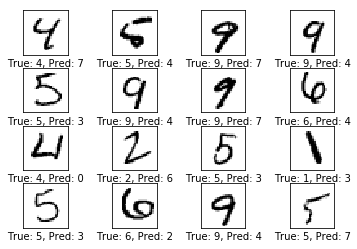

In [53]:
print_test_accuracy(show_example_errors=True)

## 1000次后的准确度

1000次后能达到90%以上。

In [54]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  71.9%
Optimization Iteration:    201, Training Accuracy:  68.8%
Optimization Iteration:    301, Training Accuracy:  82.8%
Optimization Iteration:    401, Training Accuracy:  92.2%
Optimization Iteration:    501, Training Accuracy:  92.2%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  92.2%
Optimization Iteration:    801, Training Accuracy:  89.1%
Optimization Iteration:    901, Training Accuracy:  93.8%
Time usage: 0:00:10


Accuracy on Test-Set: 92.7% (9273 / 10000)
Example errors:


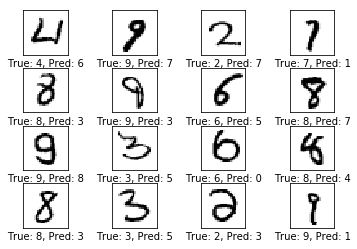

In [55]:
print_test_accuracy(show_example_errors=True)

## 10,000次后的准确度

10,000后能达到99%左右。

In [56]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  92.2%
Optimization Iteration:   1301, Training Accuracy:  87.5%
Optimization Iteration:   1401, Training Accuracy:  90.6%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  92.2%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy: 100.0%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy: 100.0%
Optimization Iteration:   2501, Training Accuracy:  95.3%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.7% (9872 / 10000)
Example errors:


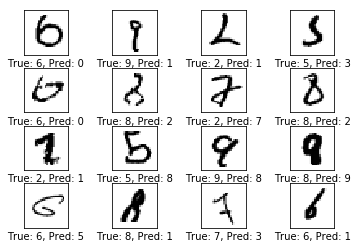

Confusion Matrix:
[[ 975    0    0    0    0    0    1    1    3    0]
 [   0 1131    2    0    0    0    1    0    1    0]
 [   2    6 1017    1    1    0    0    2    3    0]
 [   1    0    2 1000    0    2    0    3    2    0]
 [   0    1    0    0  975    0    0    2    2    2]
 [   2    0    0    4    0  878    1    2    3    2]
 [   9    3    0    0    4    3  938    0    1    0]
 [   1    1    5    1    0    0    0 1019    1    0]
 [   5    2    4    0    1    0    0    4  955    3]
 [   4    6    1    3    4    1    0    4    2  984]]


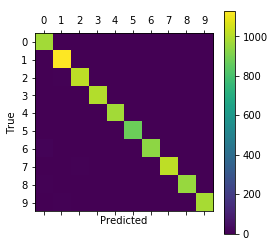

In [57]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## 查看权重和网络层
为了能理解卷积神经网络为什么可以识别手写体的数字，我们可以查看过滤器及其输出的图片。

### 卷积层的过滤器权重图形

In [58]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 卷积层输出的图片

In [59]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 输入图片

输入图片的展示辅助函数

In [60]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

展现test set里的一个图片如下

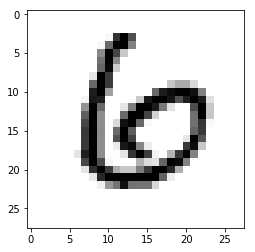

In [61]:
image1 = data.test.images[11]
plot_image(image1)

另一个图片

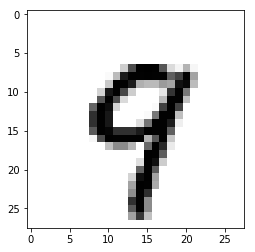

In [62]:
image2 = data.test.images[12]
plot_image(image2)

### 第一个卷积层

第一个卷积层如下图所示，红色代表正值，蓝色代表负值

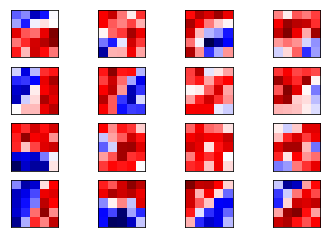

In [63]:
plot_conv_weights(weights=weights_conv1)

把这些过滤器用到第一张图片后得到以下输出。这些图片从28x28down sample成14x14。

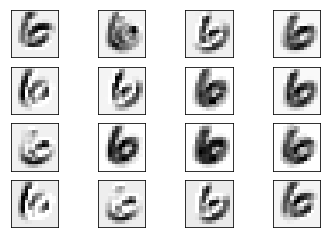

In [64]:
plot_conv_layer(layer=layer_conv1, image=image1)

第二张图片

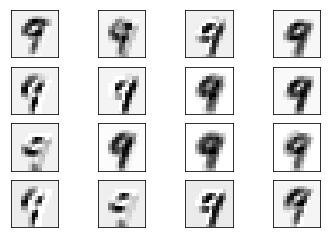

In [65]:
plot_conv_layer(layer=layer_conv1, image=image2)

### 第二个卷积层

因为第一个卷积层有16个输出channel，所以第二个卷积层有16个输入channel，每一个输入channel对应一个filters的子集。每个子集又有36个filter（对应第二个卷积层有36个输出channel）。
这里只打印16个子集里的第一个。

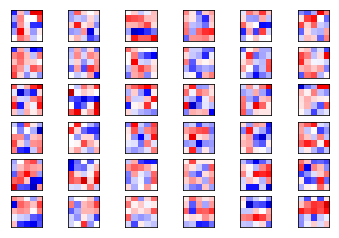

In [66]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

总共有16个这样的过滤器集合，我们再显示一个

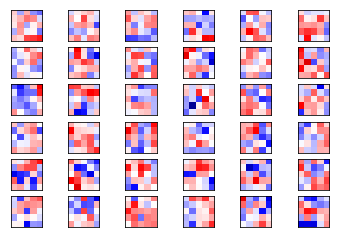

In [67]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

这些过滤器的图片仍然不太好理解，让我们看看其输出的图片。

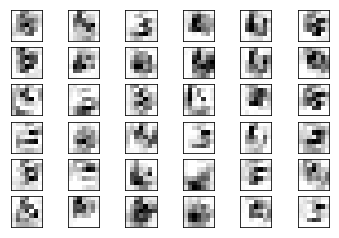

In [68]:
plot_conv_layer(layer=layer_conv2, image=image1)

下面是对第二张图片的输出

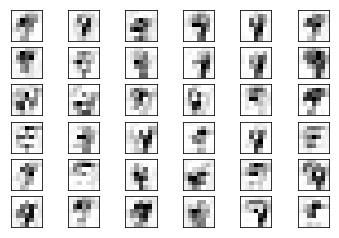

In [69]:
plot_conv_layer(layer=layer_conv2, image=image2)

这些图片表面，第二层卷积层也许识别出一些在原始图片中并不明显的线条或其他模式。

## 保存和加载模型

通过保存和加载tensorflow模型的参数，可以把训练得到的模型保存。对于一些需要长时间训练的模型，就可以利用分段时间进行训练，比如白天使用工作电脑，晚上用于训练模型。

In [70]:
import os
saver = tf.train.Saver()
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
saver.save(session, save_path)



'checkpoints/best_validation'

In [71]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()

### 关闭 TensorFlow Session

关闭Tensorflow Session可以释放资源。

## 结论

卷积神经网络比简单的线性神经网络性能更好。准确率大约能达到99%。相比之下，简单的线性神经网络只能达到91%。

但卷积神经网络也更复杂，其过滤器的参数如权重值并不是很容易让人能够理解其工作原理。

因此，可视化其参数和输出图形会有助与我们理解其中的原理。

## 用TensorBoard可视化tensorflow的计算过程和结果

In [72]:
#for embedding in tensorboard
import os 
import sys
import urllib

#versioning, urllib named differently for dif python versions
if sys.version_info[0] >= 3:
  from urllib.request import urlretrieve
else:
  from urllib import urlretrieve

#define our github URLs
GITHUB_URL ='http://raw.githubusercontent.com/mamcgrath/TensorBoard-TF-Dev-Summit-Tutorial/master/'

### MNIST EMBEDDINGS ###
#downloads and reads the data
#The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).
#very MNIST data point has two parts: an image of a handwritten digit and a corresponding label. We'll call the images "x" and the labels "y".
#Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:
#https://www.tensorflow.org/images/MNIST-Matrix.png
#mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=LOGDIR + 'data', one_hot=True)
### Get a sprite and labels file for the embedding projector ###
#If you have images associated with your embeddings, you will need to produce a single image consisting of
# small thumbnails of each data point. This is known as the sprite image. The sprite should have the same number 
#of rows and columns with thumbnails stored in row-first order: the first data point placed in the 
#top left and the last data point in the bottom right:
#TSV is a file extension for a tab-delimited file used with spreadsheet software. 
#TSV stands for Tab Separated Values. TSV files are used for raw data and can be 
#imported into and exported from spreadsheet software.
if not os.path.exists(logdir + 'labels_1024.tsv'):
    urlretrieve(GITHUB_URL + 'labels_1024.tsv', logdir + 'labels_1024.tsv')
if not os.path.exists(logdir + 'sprite_1024.png'):
    urlretrieve(GITHUB_URL + 'sprite_1024.png', logdir + 'sprite_1024.png')



为了更好地使用tensorboard时，需要加上scope，这样能更好地呈现系统结构并易于理解。下面比较没有任何sope和加了scope之后的graph

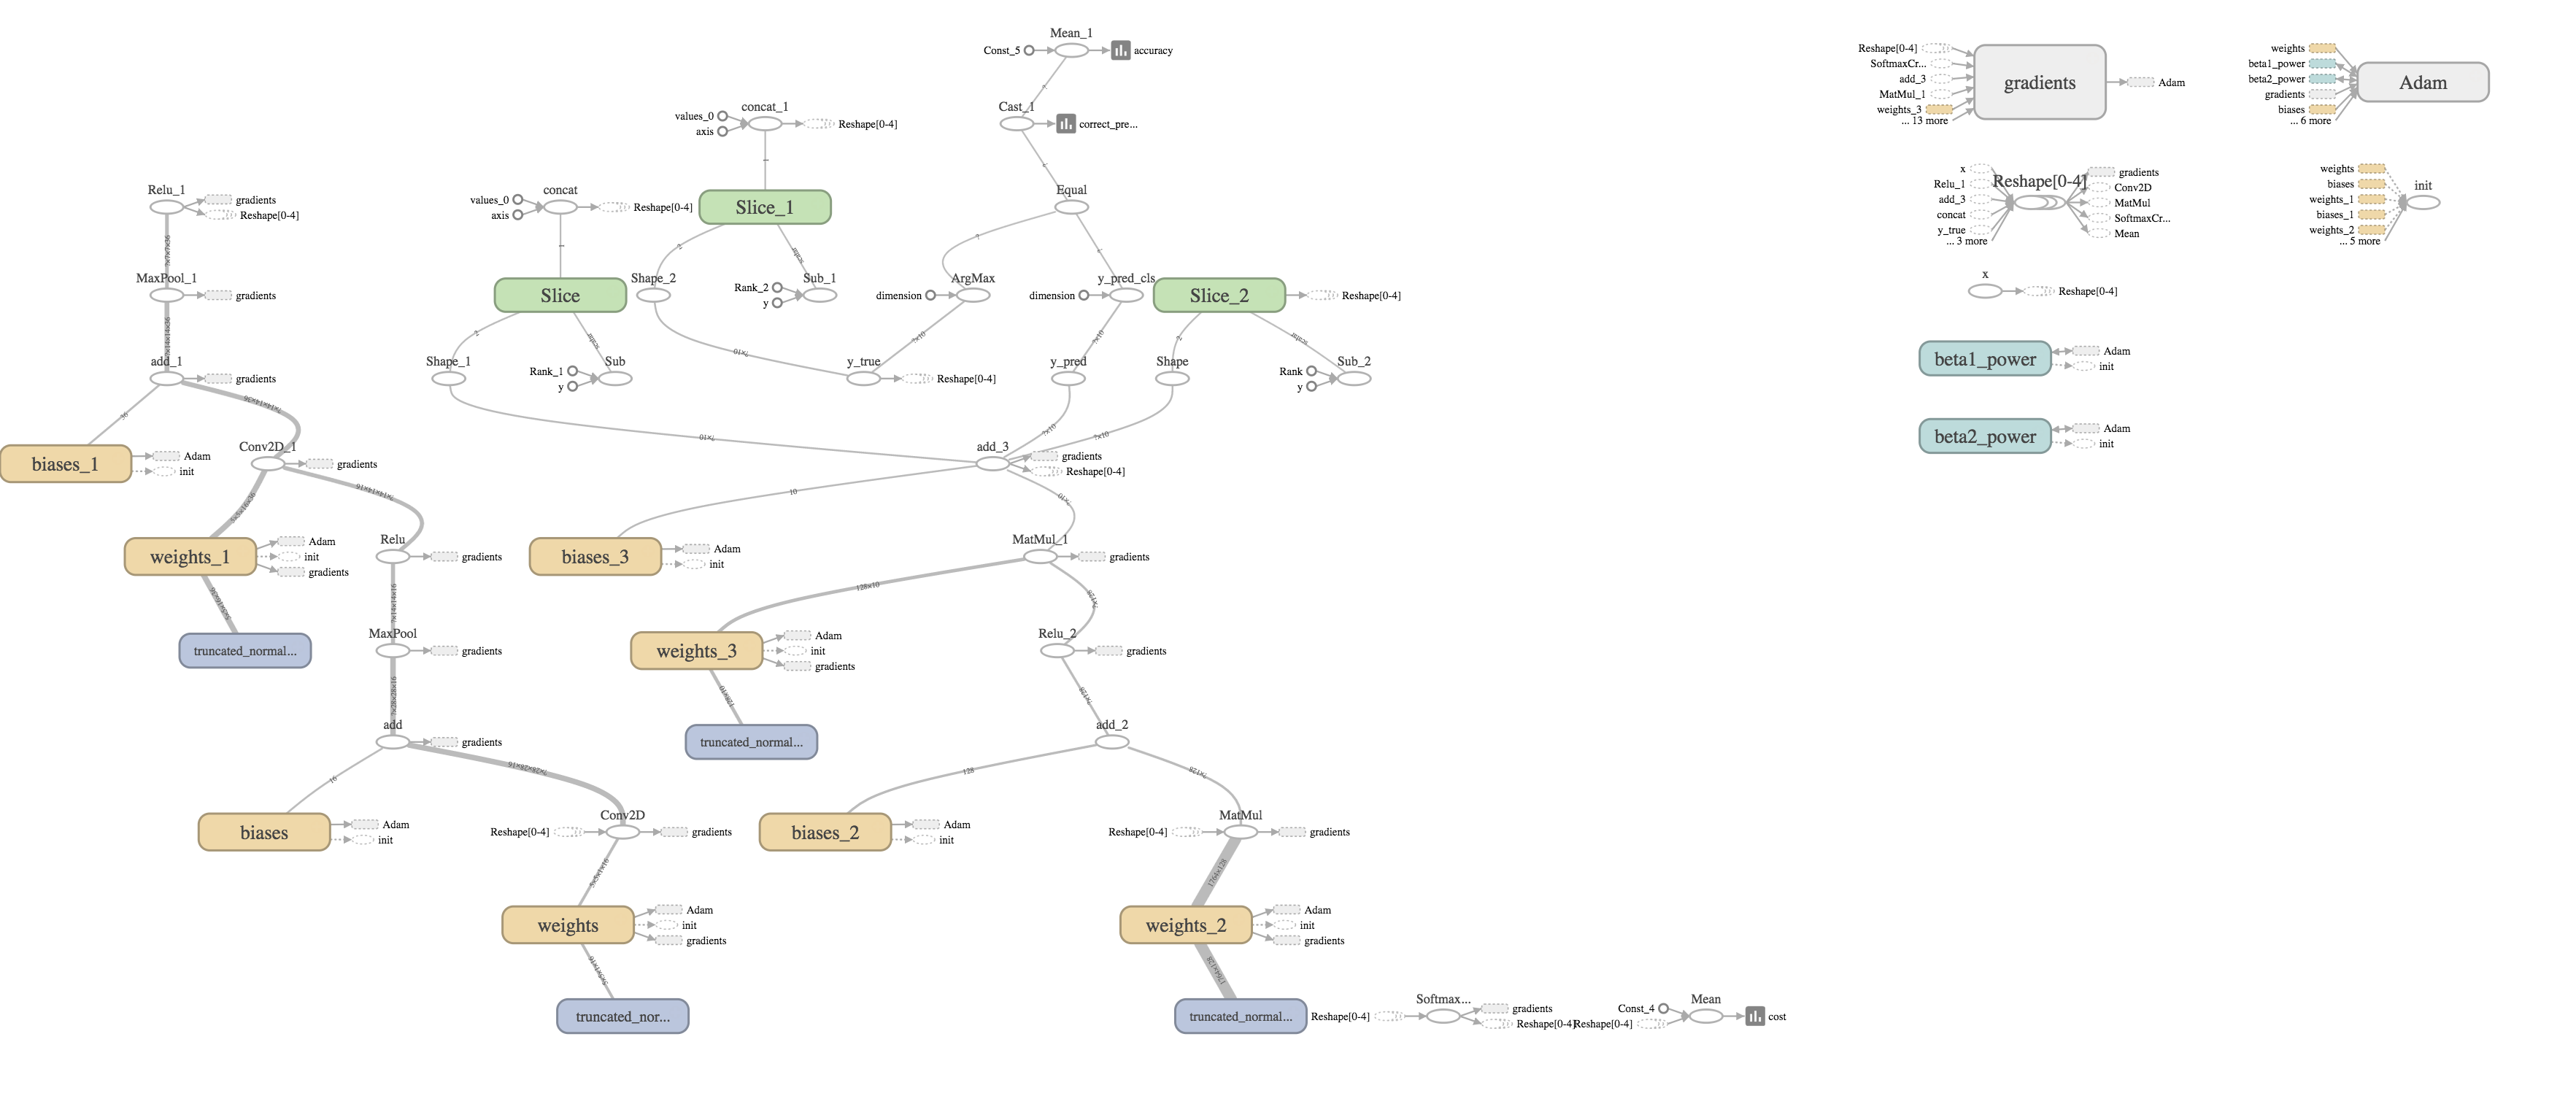

In [73]:
Image('images/graph-run-no-scope.png')
#writer.close()

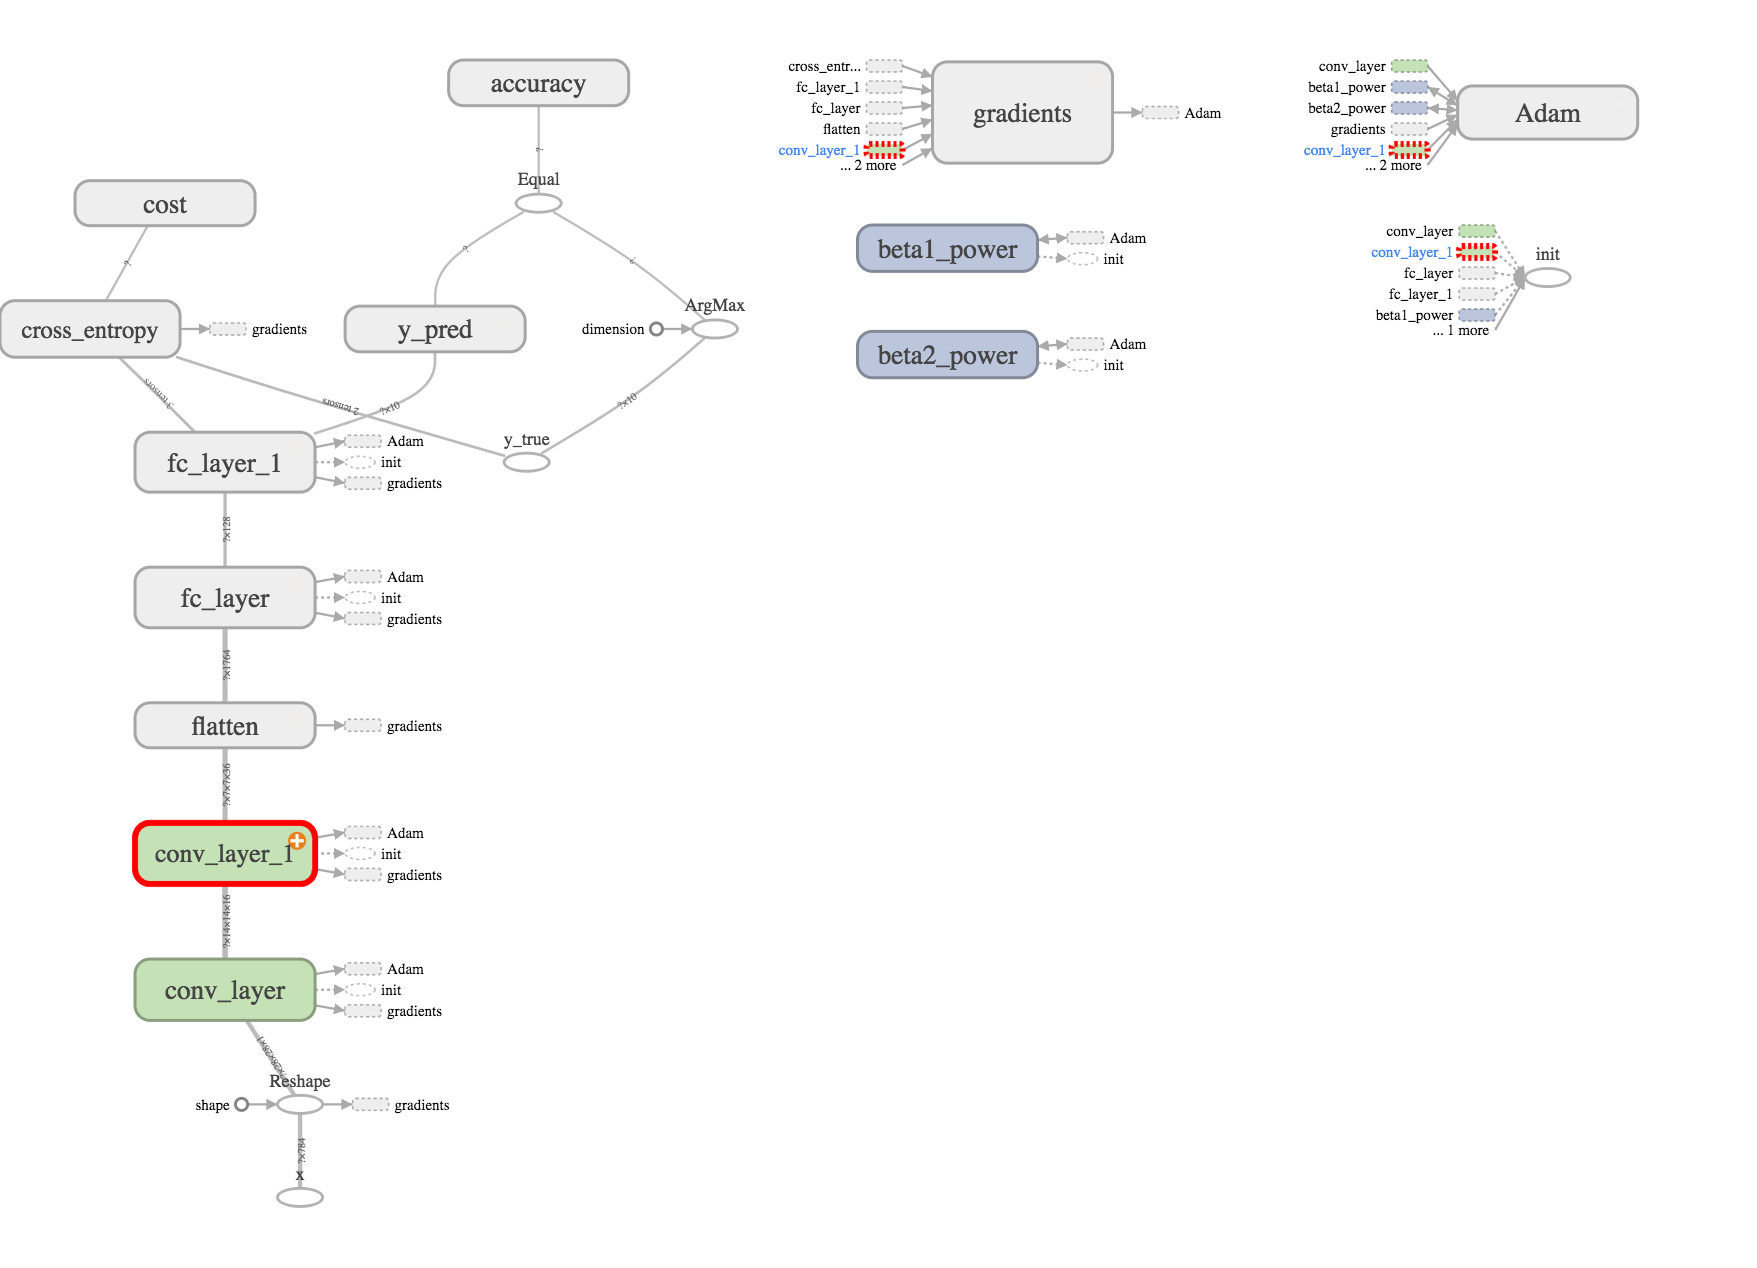

In [74]:
Image('images/graph-run-scope.png')


tensorboard里除了有computation graph，还可以分析Embedding, Scalar值，Histogram, 和Distribution。

## Use Google Inception Model

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import inception as inception

In [8]:
inception.data_dir = 'inception/'

In [9]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [10]:
model = inception.Inception()

In [11]:
def classify(image_path):
    # Display the image.
    display(Image(image_path))

    # Use the Inception model to classify the image.
    pred = model.classify(image_path=image_path)

    # Print the scores and names for the top-10 predictions.
    model.print_scores(pred=pred, k=10, only_first_name=True)    

In [12]:
def plot_resized_image(image_path):
    # Get the resized image from the Inception model.
    resized_image = model.get_resized_image(image_path=image_path)

    # Plot the image.
    plt.imshow(resized_image, interpolation='nearest')
    
    # Ensure that the plot is shown.
    plt.show()

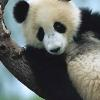

89.11% : giant panda
 0.78% : indri
 0.30% : lesser panda
 0.15% : custard apple
 0.12% : earthstar
 0.09% : sea urchin
 0.05% : forklift
 0.05% : digital watch
 0.05% : gibbon
 0.05% : go-kart


In [13]:
from IPython.display import Image, display

image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')
classify(image_path)